Загрузим бандл

In [18]:
project_name = 'gg_project'
dataset_name = 'gg_lenta_big'
bucket = 'ggbucket'


In [4]:
from pathlib import Path
from tg.grammar_ru.common.loc import Loc
from dotenv import load_dotenv
load_dotenv(Loc.root_path / 'environment.env')


True

Создадим бакет

In [5]:
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
# S3YandexHandler.create_bucket(bucket)


In [19]:
bundle_folder = Loc.data_cache_path/'bundles/grammatical_gender/big'


In [7]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle

# db = DataBundle.load(bundle_folder)
# idb = IndexedDataBundle(db.index, db)
# s = db.src
#len(s.sentence_id.unique()), len(s.word_id.unique())# (479563, 10097148)



In [8]:

import plotly.express as px
# df = px.data.tips()
# fig = px.histogram(s.groupby('sentence_id').word_id.count(), title='Распределение числа слов в предложении')
# fig.show()


In [20]:
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
S3YandexHandler.upload_folder(bucket, s3path, bundle_folder)


In [10]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler


### Обучение. Далее - `gg_run_training.py`

In [32]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
import ast 

def get_tasks_list(tasks_list_s3_path, bucket):
    tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
    S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
    with open(tmp_local_file,'r') as f:
        tasks = ast.literal_eval(f.read())

In [33]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.ml.components.yandex_delivery.datasphere_tools import *
import ast
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer
from typing import List


In [34]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_11:38:18.460849.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
# metrics


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.385852,2022-12-09 11:39:47.973667,gg_task 11:38:18.460985
1,accuracy_display,0,0.380557,2022-12-09 11:39:47.973667,gg_task 11:38:18.460985
2,loss,0,0.185628,2022-12-09 11:39:47.973667,gg_task 11:38:18.460985
3,iteration,0,0.000000,2022-12-09 11:39:47.973667,gg_task 11:38:18.460985
4,accuracy_test,1,0.385852,2022-12-09 11:41:16.658111,gg_task 11:38:18.460985
5,accuracy_display,1,0.380557,2022-12-09 11:41:16.658111,gg_task 11:38:18.460985
6,loss,1,0.183456,2022-12-09 11:41:16.658111,gg_task 11:38:18.460985
7,iteration,1,1.000000,2022-12-09 11:41:16.658111,gg_task 11:38:18.460985


In [24]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display')


job_id,gg_task 11:38:18.460985
0,0.380557
1,0.380557


####  debug net

In [17]:
import matplotlib.pyplot as plt
# plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display'))


In [11]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle

from tg.common.ml import batched_training as bt
from tg.common.ml.batched_training import torch as btt
from tg.common.ml.batched_training import context as btc
from tg.common.ml import dft
from yo_fluq_ds import fluq


from tg.grammar_ru.ml.components.attention_network import AttentionNetwork
from tg.common.ml.batched_training.torch.networks.lstm_network import LSTMFinalizer

from tg.grammar_ru.ml.components.extractor_settings import CoreExtractor
from tg.grammar_ru.ml.components.plain_context_builder import PlainContextBuilder
import datetime
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory
from tg.grammar_ru.ml.components.training_task_factory import Conventions
from tg.common.ml.training_core import TrainingEnvironment
from tg.grammar_ru.ml.components.contextual_binding import ContextualBinding, ContextualNetworkType

from tg.grammar_ru.ml.components.yandex_delivery.training_job import TrainingJob
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.common.delivery.jobs import SSHDockerJobRoutine, DockerOptions
from tg.common.delivery.packaging import FakeContainerHandler

from tg.grammar_ru.common import Loc
from sklearn.metrics import roc_auc_score
from typing import Dict, Optional  # TODO delete redundant
from tg.common.delivery.training.architecture import FileCacheTrainingEnvironment
from tg.grammar_ru.ml.components.yandex_delivery.docker_tools import deploy_container
from tg.common.delivery.jobs.ssh_docker_job_routine import build_container
from tg.common.ml.batched_training.torch.networks import FeedForwardNetwork, FullyConnectedNetwork
import torch
from pathlib import Path
from dotenv import load_dotenv

from tg.grammar_ru.common import Loc

load_dotenv(Loc.root_path / 'environment.env')

project_name = 'gg_project'
dataset_name = 'gg_dataset'
bucket = 'ggbucket'


class MulticlassMetrics(bt.Metric):
    def __init__(self, add_accuracy=True, add_rating=False):
        self.add_accuracy = add_accuracy
        self.add_rating = add_rating

    def get_names(self):
        result = []
        if self.add_accuracy:
            result.append('accuracy')
        if self.add_rating:
            result.append('rating')
        return result

    def measure(self, df, _):
        prefix = 'true_label_'
        labels = []
        for c in df.columns:
            if c.startswith(prefix):
                labels.append(c.replace(prefix, ''))

        def ustack(df, prefix, cols, name):
            df = df[[prefix+c for c in cols]]
            df.columns = [c for c in cols]
            df = df.unstack().to_frame(name)
            return df

        predicted = ustack(df, 'predicted_label_', labels, 'predicted')
        true = ustack(df, 'true_label_', labels, 'true')
        df = predicted.merge(true, left_index=True,
                             right_index=True).reset_index()
        df.columns = ['label', 'sample', 'predicted', 'true']
        df = df.feed(fluq.add_ordering_column(
            'sample', ('predicted', False), 'predicted_rating'))

        match = (df.loc[df.predicted_rating ==
                 0].set_index('sample').true > 0.5)
        rating = df.loc[df.true > 0.5].set_index('sample').predicted_rating
        result = []
        if self.add_accuracy:
            result.append(match.mean())
        if self.add_rating:
            result.append(rating.mean())
        return result


def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                       .build(Conventions.LabelFrame)
                       .index()
                       .apply(take_columns=['label'], transformer=dft.DataFrameTransformerFactory.default_factory())
                       )
    return label_extractor


class MyNetworkFactory:
    def __init__(self, nn_head_factory):
        self.nn_head_factory = nn_head_factory

    def create_network(self, task, input):  # input is batch ~ sample
        nn_head = self.nn_head_factory.create_network(task=None, input=input)
        head_out = nn_head(input)
        hidden_size = head_out.shape[1]
        labels_count = input['label'].shape[1]
        nn_tail = FullyConnectedNetwork(
            sizes=[], input=hidden_size, output=labels_count)
        # return FeedForwardNetwork(nn_head, nn_tail, torch.nn.Softmax(dim=1))
        return FeedForwardNetwork(nn_head, nn_tail)


class ClassificationTask(TaskFactory):
    def get_network(self, _, sample):
        assembled_network_factory = MyNetworkFactory(self.nn_head_factory)
        assembled_network = assembled_network_factory.create_network(
            task=None, input=sample)
        return assembled_network

    def create_task(
        self, data: IndexedDataBundle,
            env: Optional[TrainingEnvironment] = None) -> None:

        metrics = bt.MetricPool().add(MulticlassMetrics())
        self.instantiate_default_task(
            epoch_count=2,
            batch_size=100,
            mini_batch_size=50,
            mini_epoch_count=1,
            metric_pool=metrics
        )

        plain_context_builder = PlainContextBuilder(include_zero_offset=False,
                                                    left_to_right_contexts_proportion=1)

        plain_context = ContextualBinding(
            name='plain_context',
            context_length=3,
            network_type=ContextualNetworkType.Plain,
            hidden_size=[30],
            context_builder=plain_context_builder,
            extractor=CoreExtractor(join_column='another_word_id'),
            debug=False
        )
        self.nn_head_factory = plain_context.create_network_factory(
            task=None, input=None)  # TODO could be better?
        core_extractor = plain_context.create_extractor(task=None, bundle=data)
        self.setup_batcher(data, [core_extractor, get_multilabel_extractor()])
        self.setup_model(self.get_network)


def get_training_job() -> TrainingJob:
    task = ClassificationTask()
    task.info["dataset"] = dataset_name
    task.info["name"] = "gg_task"

    job = TrainingJob(
        tasks=[task],
        project_name=project_name,
        bucket=bucket
    )
    return job


job = get_training_job()

routine = SSHDockerJobRoutine(
    job=job,
    remote_host_address=None,
    remote_host_user=None,
    handler_factory=FakeContainerHandler.Factory(),
    options=DockerOptions(propagate_environmental_variables=["AWS_ACCESS_KEY_ID",
                                                             "AWS_SECRET_ACCESS_KEY"])
)
# tag = 'v_' + datetime.datetime.now().time().strftime("%H_%M_%S")
# dockerhub_repo = 'grammar_repo'  # name of your repo
# dockerhub_login = 'sergio0x0'  # your login

# local_img = 'gg_img'


# job.run()
# b_path = Loc.bundles_path/'grammatical_gender/toy'
# data = DataBundle.load(b_path)

# task = ClassificationTask()
# task.create_task(data)
# temp_batch = task.task.generate_sample_batch(data, 0)


In [12]:
# net = task.task.model_handler.network


In [13]:
# net(temp_batch)


In [14]:
# net


#### build bundle.py error on Full lenta 

cat nohup.out | tail -n 5

2022-12-15 21:42:14.310782+00:00 INFO: Processed 48077323 words. 251/869
2022-12-15 21:42:46.130967+00:00 INFO: Writing 2 frames, 35747735 words, to write 49992, to keep 35697743
2022-12-15 21:42:47.162703+00:00 INFO: Processed 48294463 words. 252/869
2022-12-15 21:43:15.324902+00:00 INFO: Writing 2 frames, 35847701 words, to write 49979, to keep 35797722
2022-12-15 21:43:17.499093+00:00 INFO: Processed 48444421 words. 253/869

Собрал бандл из 200 файлов

### EDA

In [21]:
db = DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/toy')
idb = IndexedDataBundle(db.index, db)
s = db.src

#### Размеры датасетов

(249907, 2499299, 10097148)

In [45]:
# (DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/toy').src.shape[0],
# DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/big').src.shape[0],
# DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/full').src.shape[0])

In [41]:
s.shape[0]

249907

In [ ]:
import pandas as pd
pd.value_counts()

In [46]:
s.label.value_counts(normalize=True)  # toy


-1    0.442000
 0    0.227096
 1    0.143353
 3    0.094583
 2    0.092967
Name: label, dtype: float64

In [51]:
s[s.label==3].word.head(30)

25          которых
26        оказались
38          финских
46        проживает
56         сообщает
60      задержанные
61        оказались
62       хоккейными
65          которые
66        распивали
67      алкогольные
70     общественных
78       доставляли
81      подвыпившие
86        карманные
94        мобильных
107      британских
108     Королевских
109             ВВС
111        передает
135           какие
145          данным
153         оцепили
154      британские
177       иракскими
197           Винчи
200      сообщается
226      оскорбляет
227        верующих
231       извращает
Name: word, dtype: object

## Результаты обучения

In [52]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_11:43:02.110706.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
metrics


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.495043,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
1,accuracy_display,0,0.493511,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
2,loss,0,0.166821,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
3,iteration,0,0.000000,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
4,accuracy_test,1,0.504205,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
5,accuracy_display,1,0.502487,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
6,loss,1,0.157089,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
7,iteration,1,1.000000,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
8,accuracy_test,2,0.508279,2022-12-16 12:11:45.625511,gg_task_lenta_big_10K_4ep 11:43:02.110772
9,accuracy_display,2,0.507149,2022-12-16 12:11:45.625511,gg_task_lenta_big_10K_4ep 11:43:02.110772


In [49]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display')

job_id,gg_task_lenta_big_10K_4ep 11:43:02.110772
0,0.493511
1,0.502487
2,0.507149
3,0.511105


In [50]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_test')

job_id,gg_task_lenta_big_10K_4ep 11:43:02.110772
0,0.495043
1,0.504205
2,0.508279
3,0.512254


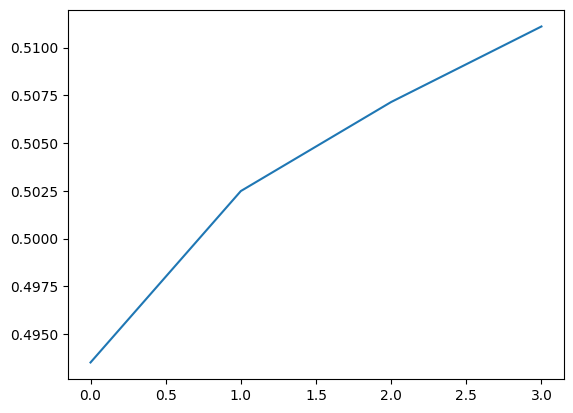

In [38]:
import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display'))

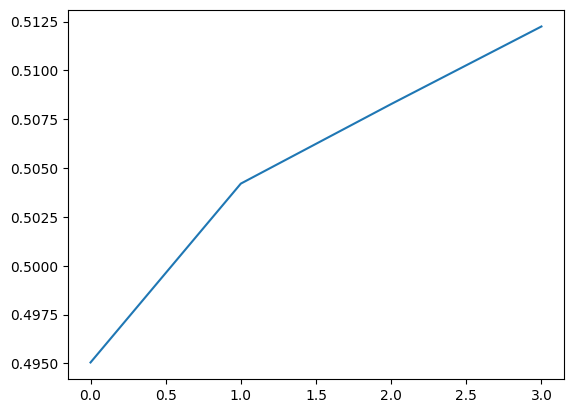

In [39]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_test'))
